<a href="https://www.kaggle.com/code/lisphilar/covid-19-government-jhu-data-in-japan?scriptVersionId=103217095" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
In this notebook, we will compare the number of cases announced by Japanese government and gathered by Johns Hopkins University.

(Japanese goverment annouced)
* Primary source: [Ministry of Health, Labour and Welefare HP (in English)](https://www.mhlw.go.jp/stf/seisakunitsuite/bunya/newpage_00032.html)
* Secondary source: [COVID-19 dataset in Japan](https://www.kaggle.com/lisphilar/covid19-dataset-in-japan)

(Johns Hoplins University gathered)
* Primary source: [COVID-19 Data Repository by CSSE at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19)
* Secondary source: [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/kernels)

In [1]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'13Aug2022 15:45'

## Package

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pandas as pd
import seaborn as sns
# Matplotlib
%matplotlib inline
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
# Pandas
pd.set_option("display.max_colwidth", 1000)

## Functions

In [3]:
def line_plot(df, title, xlabel=None, ylabel="Cases",
              h=None, v=None, xlim=(None, None), ylim=(0, None),
              math_scale=True, x_logscale=False, y_logscale=False, y_integer=False,
              show_legend=True, bbox_to_anchor=(1.02, 0),  bbox_loc="lower left"):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    # Scale
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    if x_logscale:
        ax.set_xscale("log")
        if xlim[0] == 0:
            xlim = (None, None)
    if y_logscale:
        ax.set_yscale("log")
        if ylim[0] == 0:
            ylim = (None, None)
    if y_integer:
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        ax.yaxis.set_major_formatter(fmt)
    # Set metadata of figure
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    if show_legend:
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=bbox_loc, borderaxespad=0)
    else:
        ax.legend().set_visible(False)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle=":")
    if v is not None:
        if not isinstance(v, list):
            v = [v]
        for value in v:
            ax.axvline(x=value, color="black", linestyle=":")
    plt.tight_layout()
    plt.show()

# Datasets

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths_US.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed_US.csv
/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv
/kaggle/input/covid19-dataset-in-japan/covid_jpn_prefecture.csv
/kaggle/input/covid19-dataset-in-japan/covid_jpn_total.csv
/kaggle/input/covid19-dataset-in-japan/covid_jpn_metadata.csv


## Government data

### Raw data

In [5]:
gov_raw = pd.read_csv("/kaggle/input/covid19-dataset-in-japan/covid_jpn_total.csv")
gov_raw.tail()

,Date,Location,Positive,Tested,Symptomatic,Asymptomatic,Sym-unknown,Hosp_require,Hosp_mild,Hosp_severe,Hosp_unknown,Hosp_waiting,Discharged,Fatal,Vaccinated_1st,Vaccinated_2nd,Vaccinated_3rd
2717,2022-08-12,Airport,20973,2332931.0,NaN,NaN,NaN,240.0,NaN,0,NaN,NaN,20725,8,0.0,0.0,0.0
2718,2022-08-12,Returnee,15,829.0,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,15,0,0.0,0.0,0.0
2719,2022-08-13,Domestic,15257647,64129801.0,NaN,NaN,NaN,1965594.0,NaN,625,NaN,NaN,13185178,34755,0.0,0.0,0.0
2720,2022-08-13,Airport,21006,2333469.0,NaN,NaN,NaN,243.0,NaN,0,NaN,NaN,20755,8,0.0,0.0,0.0
2721,2022-08-13,Returnee,15,829.0,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,15,0,0.0,0.0,0.0


### Data cleaning

In [6]:
# https://www.kaggle.com/lisphilar/eda-of-japan-dataset
df = gov_raw.copy()
df.dropna(how="all", inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df.groupby("Location").apply(
    lambda x: x.set_index("Date").resample("D").interpolate(method="linear")
)
df = df.drop("Location", axis=1).reset_index()
df = df.sort_values("Date").reset_index(drop=True)
sel = df.columns.isin(["Location", "Date"])
df.loc[:, ~sel] = df.loc[:, ~sel].fillna(0).astype(np.int64)
# Select Confirmed/Recovered/Fatal
df = df.loc[:, ["Location", "Date", "Positive", "Fatal", "Discharged"]]
df = df.rename({"Positive": "Confirmed", "Discharged": "Recovered"}, axis=1)
# Show
gov_df = df.copy()
gov_df.tail(9)

,Location,Date,Confirmed,Fatal,Recovered
2723,Domestic,2022-08-11,14840423,34315,12779458
2724,Returnee,2022-08-11,15,0,15
2725,Airport,2022-08-11,20937,8,20682
2726,Airport,2022-08-12,20973,8,20725
2727,Returnee,2022-08-12,15,0,15
2728,Domestic,2022-08-12,15065316,34529,12938421
2729,Airport,2022-08-13,21006,8,20755
2730,Domestic,2022-08-13,15257647,34755,13185178
2731,Returnee,2022-08-13,15,0,15


### Government announced, total

In [7]:
gov_total_df = gov_df.groupby("Date").sum()
gov_total_df.tail()

,Confirmed,Fatal,Recovered
Date,,,
2022-08-09,14421539,33825,12349238
2022-08-10,14618271,34075,12545387
2022-08-11,14861375,34323,12800155
2022-08-12,15086304,34537,12959161
2022-08-13,15278668,34763,13205948


### Government announced, domestic
Without airport quarantine and returnees by chartered flights.

In [8]:
df = gov_df.copy()
df = df.loc[df["Location"] == "Domestic", :].drop("Location", axis=1)
df = df.groupby("Date").last()
gov_dom_df = df.copy()
gov_dom_df.tail()

,Confirmed,Fatal,Recovered
Date,,,
2022-08-09,14400634,33817,12328617
2022-08-10,14597345,34067,12524718
2022-08-11,14840423,34315,12779458
2022-08-12,15065316,34529,12938421
2022-08-13,15257647,34755,13185178


## JHU data

### Raw data

In [9]:
jhu_raw = pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv")
jhu_raw.loc[jhu_raw["Country/Region"] == "Japan", :]

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
35,36,01/22/2020,NaN,Japan,1/22/2020 17:00,2.0,0.0,0.0
75,76,01/23/2020,NaN,Japan,1/23/20 17:00,1.0,0.0,0.0
123,124,01/24/2020,NaN,Japan,1/24/20 17:00,2.0,0.0,0.0
166,167,01/25/2020,NaN,Japan,1/25/20 17:00,2.0,0.0,0.0
214,215,01/26/2020,NaN,Japan,1/26/20 16:00,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...
306367,306368,05/29/2021,Unknown,Japan,2021-05-30 04:20:55,8.0,0.0,8.0
306401,306402,05/29/2021,Wakayama,Japan,2021-05-30 04:20:55,2612.0,41.0,2410.0
306413,306414,05/29/2021,Yamagata,Japan,2021-05-30 04:20:55,1963.0,42.0,1692.0
306414,306415,05/29/2021,Yamaguchi,Japan,2021-05-30 04:20:55,2903.0,60.0,2330.0


### Data cleaning

In [10]:
df = jhu_raw.copy()
df = df.rename({"ObservationDate": "Date", "Deaths": "Fatal"}, axis=1)
df = df.loc[df["Country/Region"] == "Japan", ["Date", "Confirmed", "Fatal", "Recovered"]]
df["Date"] = pd.to_datetime(df["Date"])
df = df.groupby("Date").sum()
df = df.astype(np.int64)
df = df.reset_index()
jhu_df = df.copy()
jhu_df.tail()

,Date,Confirmed,Fatal,Recovered
489,2021-05-25,726586,12457,645001
490,2021-05-26,731071,12573,649955
491,2021-05-27,735234,12691,655066
492,2021-05-28,738935,12786,659576
493,2021-05-29,742539,12877,666786


## Merge

In [11]:
df = pd.merge(
    gov_total_df, gov_dom_df,
    left_index=True, right_index=True,
    suffixes=["/Total", "/Domestic"]
)
df = pd.merge(
    df.add_suffix("/GOV"), jhu_df.set_index("Date").add_suffix("/JHU"),
    left_index=True, right_index=True
)
comp_df = df.copy()
comp_df.tail()

,Confirmed/Total/GOV,Fatal/Total/GOV,Recovered/Total/GOV,Confirmed/Domestic/GOV,Fatal/Domestic/GOV,Recovered/Domestic/GOV,Confirmed/JHU,Fatal/JHU,Recovered/JHU
Date,,,,,,,,,
2021-05-25,721912,12398,645157,718984,12394,642319,726586,12457,645001
2021-05-26,725536,12497,650111,722605,12493,647273,731071,12573,649955
2021-05-27,729853,12601,655222,726912,12597,652354,735234,12691,655066
2021-05-28,733887,12714,659732,730936,12710,656861,738935,12786,659576
2021-05-29,738045,12819,666942,735092,12815,664062,742539,12877,666786


# Confirmed

In [12]:
c_df = comp_df.loc[:, comp_df.columns.str.startswith("Confirmed")]
c_df.tail(10)

,Confirmed/Total/GOV,Confirmed/Domestic/GOV,Confirmed/JHU
Date,,,
2021-05-20,698254,695360,705641
2021-05-21,704139,701255,710895
2021-05-22,709527,706620,715880
2021-05-23,714274,711360,719925
2021-05-24,718864,715940,722668
2021-05-25,721912,718984,726586
2021-05-26,725536,722605,731071
2021-05-27,729853,726912,735234
2021-05-28,733887,730936,738935


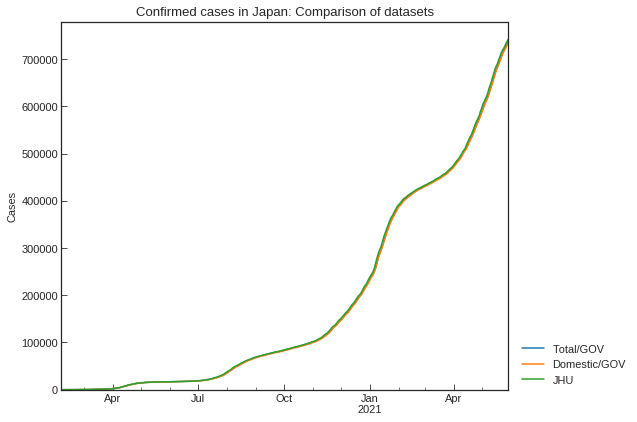

In [13]:
df = c_df.copy()
df.columns = df.columns.str.replace("Confirmed/", "")
line_plot(df, "Confirmed cases in Japan: Comparison of datasets", y_integer=True)

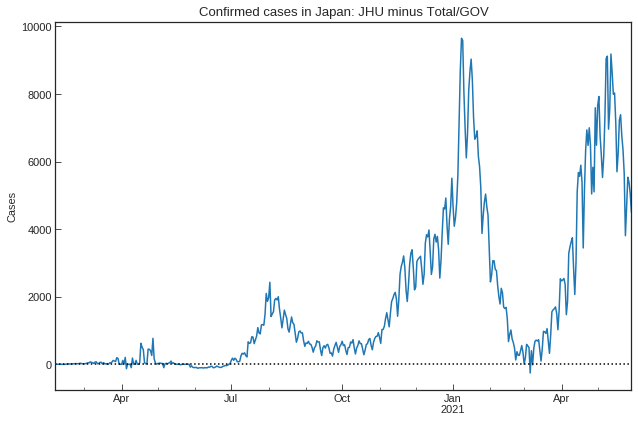

In [14]:
df = c_df.copy()
df.columns = df.columns.str.replace("Confirmed/", "")
series = df["JHU"] - df["Total/GOV"]
line_plot(
    series,
    "Confirmed cases in Japan: JHU minus Total/GOV",
    y_integer=True, ylim=(None, None), show_legend=False,
    h=0
)

# Fatal

In [15]:
d_df = comp_df.loc[:, comp_df.columns.str.startswith("Fatal")]
d_df.tail(10)

,Fatal/Total/GOV,Fatal/Domestic/GOV,Fatal/JHU
Date,,,
2021-05-20,11940,11936,12006
2021-05-21,12046,12042,12119
2021-05-22,12152,12148,12203
2021-05-23,12236,12232,12265
2021-05-24,12312,12308,12351
2021-05-25,12398,12394,12457
2021-05-26,12497,12493,12573
2021-05-27,12601,12597,12691
2021-05-28,12714,12710,12786


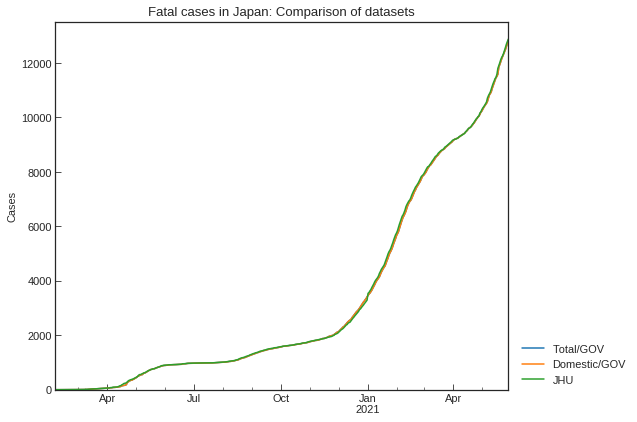

In [16]:
df = d_df.copy()
df.columns = df.columns.str.replace("Fatal/", "")
line_plot(df, "Fatal cases in Japan: Comparison of datasets", y_integer=True)

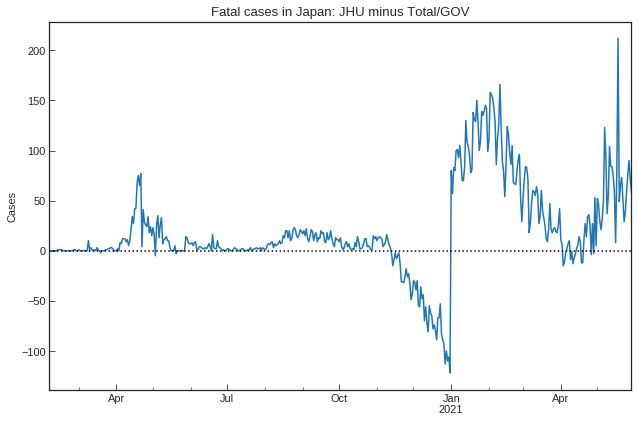

In [17]:
df = d_df.copy()
df.columns = df.columns.str.replace("Fatal/", "")
series = df["JHU"] - df["Total/GOV"]
line_plot(
    series,
    "Fatal cases in Japan: JHU minus Total/GOV",
    y_integer=True, ylim=(None, None), show_legend=False,
    h=0
)

# Recovered

In [18]:
r_df = comp_df.loc[:, comp_df.columns.str.startswith("Recovered")]
r_df.tail(10)

,Recovered/Total/GOV,Recovered/Domestic/GOV,Recovered/JHU
Date,,,
2021-05-20,615324,612524,615168
2021-05-21,621608,618796,621452
2021-05-22,628522,625696,628366
2021-05-23,634103,631273,633947
2021-05-24,639887,637057,639731
2021-05-25,645157,642319,645001
2021-05-26,650111,647273,649955
2021-05-27,655222,652354,655066
2021-05-28,659732,656861,659576


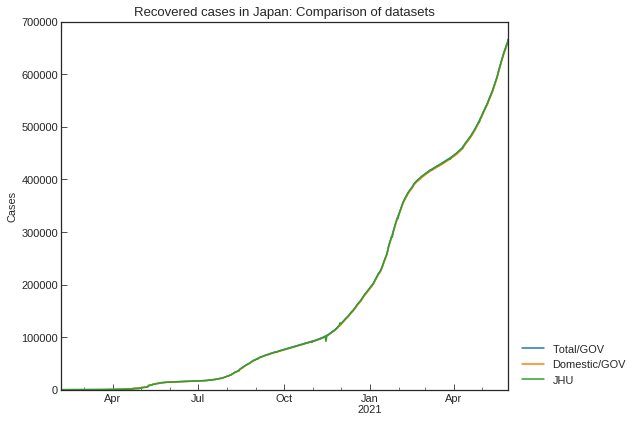

In [19]:
df = r_df.copy()
df.columns = df.columns.str.replace("Recovered/", "")
line_plot(df, "Recovered cases in Japan: Comparison of datasets", y_integer=True)

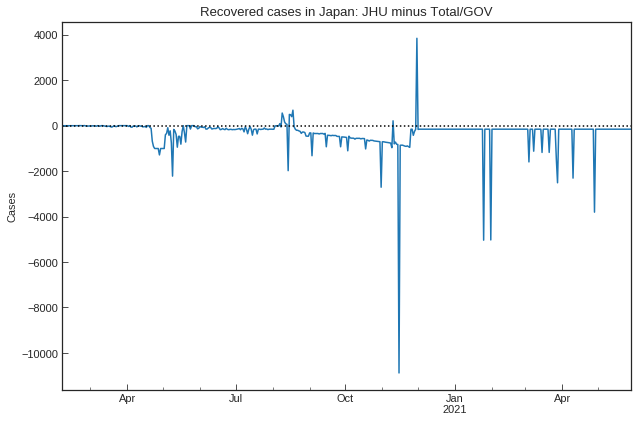

In [20]:
df = r_df.copy()
df.columns = df.columns.str.replace("Recovered/", "")
series = df["JHU"] - df["Total/GOV"]
line_plot(
    series,
    "Recovered cases in Japan: JHU minus Total/GOV",
    y_integer=True, ylim=(None, None), show_legend=False,
    h=0
)